In [1]:
path = "cmake-build-debug/Build/bin/"

max_iters = 1000000

dimensions = [5,6,7,8,9,10,12,15,20]

cmds = [{ 
            "name": "gauss_newton",
            "cmd" : "GaussNewton {function_index} {x} {y} {max_iter} {filename}"
        },
        {
            "name": "lbfgs_m3",
            "cmd" : "LBFGS {function_index} {x} {y} {m} {max_iter} {filename}",
            "m"   : 3
            
        },
        {
            "name": "newt_methods",
            "cmd" : "NewtonMethods {method} {function_index} {x} {y} {max_iter} {filename}",
            "method" : 0,
            "function_index" : 2
        },
        {
            "name": "grad_desc",
            "cmd" : "GradientDescent {function_index} 1 {x} {y} {max_iter} {filename}"
        }
        ]

In [2]:
cmds[1]["cmd"].format(method=2,function_index=1,x=1,y=1,max_iter=20,filename="asdf",m=20)

'LBFGS 1 1 1 20 20 asdf'

In [3]:
def create_cmd(cmd_entry,dim,function_index=0,max_iter=1000000):
    spring = "wol" if function_index==0 else "wl"
    m = 0
    method = 0
    if "m" in cmd_entry:
        m = cmd_entry["m"]
    if "method" in cmd_entry:
        method = cmd_entry["method"]
    if "function_index" in cmd_entry and function_index == 1:
        function_index = cmd_entry["function_index"]
        spring = "wl_pHess"
    
    return cmd_entry["cmd"].format(function_index=function_index,
                                   x=dim,
                                   y=dim,
                                   max_iter=max_iter,
                                   filename=cmd_entry["name"]+"_"+spring+"_"+str(dim)+"x"+str(dim),
                                   m=m,
                                   method=method)

In [4]:
create_cmd(cmds[2],5,1)

'NewtonMethods 0 2 5 5 1000000 newt_methods_wl_pHess_5x5'

# Different commands

❯ ./GaussNewton
Usage: input should be 'function index(0: f without length, 1: f with length), number of grid in x, number of grid in y, max iteration, filename', e.g. ./GaussNewton 1 20 20 10000 /usr/spring

❯ ./GradientDescent
Usage: input should be 'function index(0: f without length, 1: f with length),constrained spring scenario  (1 or 2 )number of grid in x, number of grid in y, max iteration, filename', e.g. ./GradientDescent 0 2 2 10000 /usr/spring

❯ ./LBFGS
Usage: input should be 'function index(0: f without length, 1: f with length), number of grid in x, number of grid in y, m, max iteration, filename', e.g. ./LBFGS 1 20 20 10 10000 /usr/spring

❯ ./NewtonMethods
Usage: input should be 'newton's method(0: standard newton, 1: projected hessian),function index(0: f without length, 1: f with length, 2: f with length with positive local hessian), number of grid in x, number of grid in y, max iteration, filename', e.g. ./NewtonMethods 0 0 2 2 10000 /usr/spring

In [5]:
import os
print(os.getcwd())

/Users/chris/Documents/GitHub/aopt/aopt-exercise7


In [6]:
os.chdir(path)


In [7]:
print(os.getcwd())

/Users/chris/Documents/GitHub/aopt/aopt-exercise7/cmake-build-debug/Build/bin


In [8]:
results = {
            "Spring without length": {},
            "Spring with length":    {}
}

### Regex match group to get numbers

group(1) = Total time<br>
group(2) = Total time evaluation<br>
group(3) = eval_f time<br>
group(4) = eval_grad time <br>
group(5) = eval_hessian time

In [28]:
import re
from subprocess import PIPE, Popen


for dim in dimensions:
    spring_type = "Spring without length"
    
    cache = {}
    
    for cmd_entry in cmds[1:4]:
        cache[cmd_entry["name"]] = {
            "Command run" : None,
            "Total time" : None,
            "Total time evaluation" : None,
            "eval_f time" : None,
            "eval_grad time" : None,
            "eval_hessian time" : None,
            "Initial MassSpring system energy" : None,
            "Objective Function Value" : None,
            "Iterations" : None,
        }

        #for size in dimensions:
        cmd = create_cmd(cmd_entry,dim)
        cache[cmd_entry["name"]]["Command run"]= cmd
        p = Popen("./"+cmd, shell=True, stdout=PIPE, stderr=PIPE)
        stdout, stderr = p.communicate()
        system_energy_pattern = re.compile(r".*energy[ ]*is[ ](-?[\d.]+(?:e[+-]?\d+)?).*iter:[ ]*([\d]*).*obj[ ]*=[ ]*(-?[\d.]+(?:e[+-]?\d+)?).*")
        for match in system_energy_pattern.finditer(str(stdout)):
            cache[cmd_entry["name"]]["Initial MassSpring system energy"]=match.group(1)
            cache[cmd_entry["name"]]["Iterations"]= match.group(2)
            cache[cmd_entry["name"]]["Objective Function Value"]= match.group(3)

        timing_pattern = re.compile(r".*total[ ]*time[ ]*:[ ]*(-?[\d.]+(?:e[-+]?\d+)?)s.*total[ ]*time[ ]*evaluation[ ]*:[ ]*(-?[\d.]+(?:e[-+]?\d+)?)s.*eval_f[ ]*time[ ]*:[ ]*(-?[\d.]+(?:e[-+]?\d+)?)s.*eval_grad[ ]*time[ ]*:[ ]*(-?[\d.]+(?:e[-+]?\d+)?)s.*eval_hess[ ]*time[ ]*:[ ]*(-?[\d.]+(?:e[-+]?\d+)?)s.*", re.MULTILINE | re.DOTALL)
        #print(cmd)
        #print(stderr)
        #print(stdout)
        for match in timing_pattern.finditer(str(stderr)):
            cache[cmd_entry["name"]]["Total time"]= match.group(1)
            cache[cmd_entry["name"]]["Total time evaluation"]=match.group(2)
            cache[cmd_entry["name"]]["eval_f time"]=match.group(3)
            cache[cmd_entry["name"]]["eval_grad time"]=match.group(4)
            cache[cmd_entry["name"]]["eval_hessian time"]=match.group(5)
    results[spring_type][str(dim)] = cache

    

### Compare Results

In [31]:
import pandas as pd
pd.DataFrame(data=results["Spring without length"]["10"])


,lbfgs_m3,newt_methods,grad_desc
Command run,LBFGS 0 10 10 3 1000000 lbfgs_m3_wol_10x10,NewtonMethods 0 0 10 10 1000000 newt_methods_w...,GradientDescent 0 1 10 10 1000000 grad_desc_wo...
Total time,6.36461,0.000763,2.84307
Total time evaluation,4.20096,0.000225,1.91873
eval_f time,3.90434,0.00001,1.77167
eval_grad time,0.29662,0.00001,0.14706
eval_hessian time,0.00000,0.00021,0.00000
Initial MassSpring system energy,2.542e+07,2.542e+07,2.542e+07
Objective Function Value,141.273,141.273,141.273
Iterations,97538,3,48455


In [32]:
def is_float(value):
    try:
        float(value)
        return True
    except:
        return False


In [33]:
dic = {}
spring_type = "Spring without length"

for column in results["Spring without length"]["5"]:

    dic[column]= {
    "Command run" : [],
    "Total time" : [],
    "Total time evaluation" : [],
    "eval_f time" : [],
    "eval_grad time" : [],
    "eval_hessian time" : [],
    "Initial MassSpring system energy" : [],
    "Objective Function Value" : [],
        "Iterations" : []
    }
    
    for dim in dimensions:
        for key in dic[column]:
            value = results[spring_type][str(dim)][column][key]
            if is_float(value):
                dic[column][key].append(float(value))
            else:
                dic[column][key].append(value)


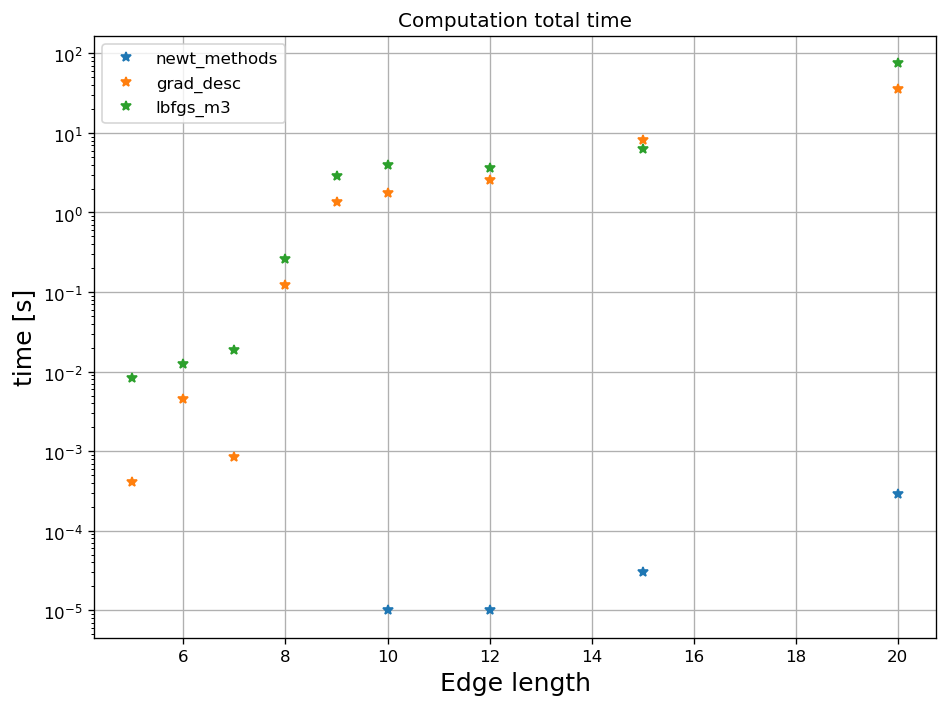

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
ax.semilogy(dimensions,dic["newt_methods"]["eval_f time"], linestyle='None', marker='*')
ax.semilogy( dimensions,dic["grad_desc"]["eval_f time"], linestyle='None', marker='*')
ax.semilogy( dimensions,dic["lbfgs_m3"]["eval_f time"], linestyle='None', marker='*')



ax.legend(["newt_methods","grad_desc","lbfgs_m3"])


ax.set_xlabel(r'Edge length', fontsize=15)
ax.set_ylabel(r'time [s]', fontsize=15)
ax.set_title('Computation total time')

ax.grid(True)
fig.tight_layout()

plt.show()

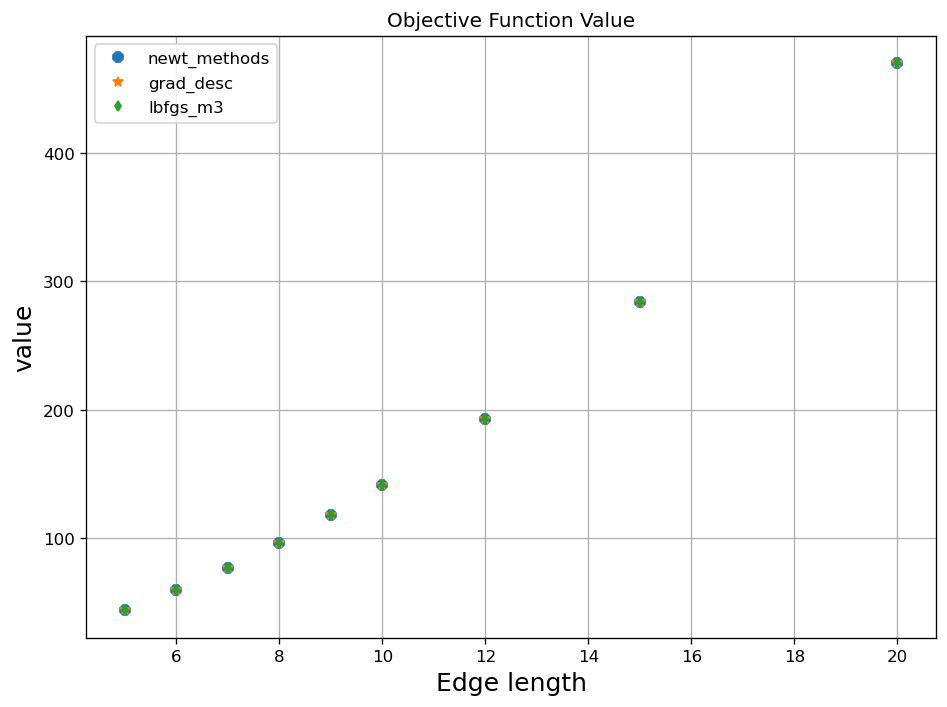

In [35]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
ax.plot(dimensions,dic["newt_methods"]["Objective Function Value"], linestyle='None', marker='8',markersize=7)
ax.plot( dimensions,dic["grad_desc"]["Objective Function Value"], linestyle='None', marker='*',markersize=6)
ax.plot( dimensions,dic["lbfgs_m3"]["Objective Function Value"], linestyle='None', marker='d',markersize=4)



ax.legend(["newt_methods","grad_desc","lbfgs_m3"])


ax.set_xlabel(r'Edge length', fontsize=15)
ax.set_ylabel(r'value', fontsize=15)
ax.set_title('Objective Function Value')

ax.grid(True)
fig.tight_layout()

plt.show()

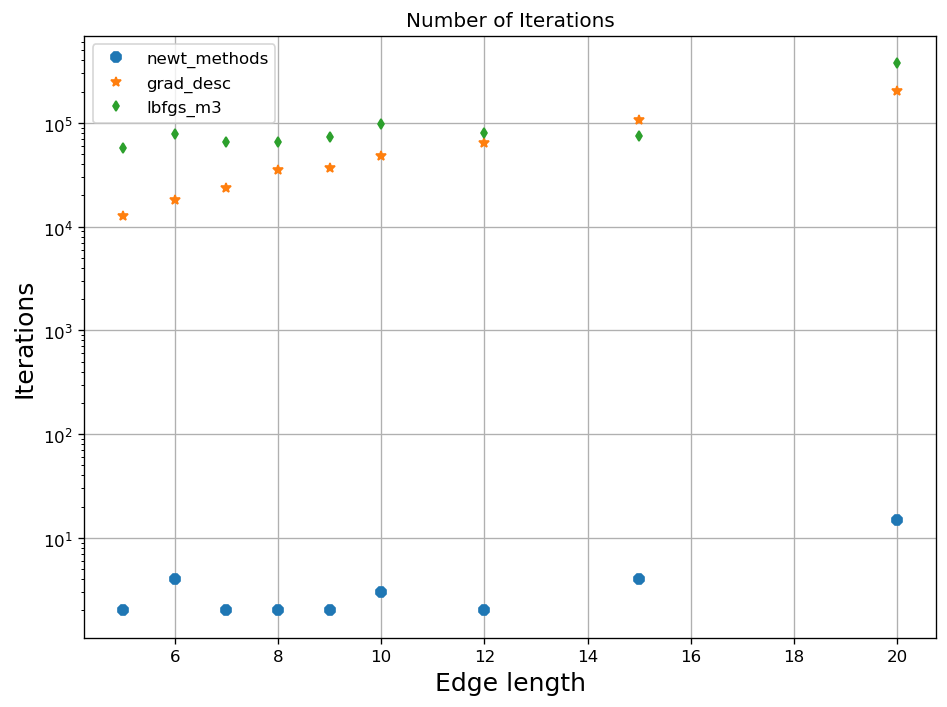

In [38]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
ax.semilogy(dimensions,dic["newt_methods"]["Iterations"], linestyle='None', marker='8',markersize=7)
ax.semilogy( dimensions,dic["grad_desc"]["Iterations"], linestyle='None', marker='*',markersize=6)
ax.semilogy( dimensions,dic["lbfgs_m3"]["Iterations"], linestyle='None', marker='d',markersize=4)



ax.legend(["newt_methods","grad_desc","lbfgs_m3"])


ax.set_xlabel(r'Edge length', fontsize=15)
ax.set_ylabel(r'Iterations', fontsize=15)
ax.set_title('Number of Iterations')

ax.grid(True)
fig.tight_layout()

plt.show()